## Load modules and data

In [1]:
## Load## Load modules and data modules
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")

#Base
from os import path
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
from tqdm.notebook import trange, tqdm
import time

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

#V1DD
from experiment.v1dd_em_client import V1DDEMClient
from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession
from stimulus_analysis.stimulus_analysis import StimulusAnalysis
from stimulus_analysis.drifting_gratings import DriftingGratings
from stimulus_analysis.natural_scenes import NaturalScenes
from stimulus_analysis.natural_movie import NaturalMovie
from stimulus_analysis import fit_utils
import analysis_tools as at
from stimulus_analysis.timing_utils import find_nearest

#User
import stimulus_analysis.decoding as dc

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/home/dwyrick/data/v1dd_in_vivo_new_segmentation" # Local on Essun for golden mouse
client = V1DDClient(base_folder)

##===== Read in drifting grating cell metrics =====##
DF_SAVE_DIR = r"/home/dwyrick/Git/v1dd_surround_suppression/dataframes"
dg_metrics = pd.read_csv(path.join(DF_SAVE_DIR, "v1dd_metrics.csv"), index_col=0, low_memory=False)
dg_metrics = dg_metrics[dg_metrics.is_valid]

ns_metrics = pd.read_csv(path.join(DF_SAVE_DIR, "ns_metrics.csv"),index_col=0, low_memory=False)


## Calculate responsiveness to natural movie

In [ ]:
##===== Load session from golden mouse =====##
goldenmouse_id = 409828; col = 1; vol = 3; plane = 3
sess = client.load_ophys_session(mouse=goldenmouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")

#Get dff traces
dff_full, ts_full = sess.get_traces(plane, trace_type='dff')
deconv_dff_full, ts_full = sess.get_traces(plane, trace_type='events')

#Only take valid cells
mask = sess.is_roi_valid(plane)
indy = np.where(mask)[0]

#Subsample
dff = dff_full[indy]; ts = ts_full
deconv_dff = deconv_dff_full[indy]
roi_ids = np.array(sess.get_rois(plane))
roi_ids_valid = roi_ids[indy]

#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("natural_movie")
stim_table = stim_table.iloc[0:28800]
stim_table.head(10)

In [ ]:
## Create stimulus object for natural scenes analysis
nm = NaturalMovie(sess, 3)
nm.response_frame_window = (0,3)

results1 = []
results2 = []
for i in range(1,5):
    nm = NaturalMovie(sess, 3)
    nm.response_frame_window = (0,i)

    nm_metrics = nm.metrics
    nm_metrics = nm_metrics.loc[nm_metrics.is_valid]

    method1_frac = np.sum(nm_metrics['frac_responsive_trials'] > 0.25)*100/len(nm_metrics)
    method2_frac = np.sum(nm_metrics['frac_responsive_trials2'] > 0.25)*100/len(nm_metrics)
    results1.append(method1_frac); results2.append(method2_frac)
    print('Comparing against null distribution (spont activity): {:.1f}%'.format(method1_frac))
    print('Other method: {:.1f}%'.format(method2_frac))


In [12]:
# trial_responses = nm.trial_responses[nm.is_roi_valid]

nm_metrics = nm.metrics
nm_metrics = nm_metrics.loc[nm_metrics.is_valid]

In [13]:
method1_frac = np.sum(nm_metrics['frac_responsive_trials'] > 0.25)*100/len(nm_metrics)
method2_frac = np.sum(nm_metrics['frac_responsive_trials2'] > 0.25)*100/len(nm_metrics)

print('Comparing against null distribution (spont activity): {:.1f}%'.format(method1_frac))
print('Other method: {:.1f}%'.format(method2_frac))

Comparing against null distribution (spont activity): 72.7%
Other method: 79.1%


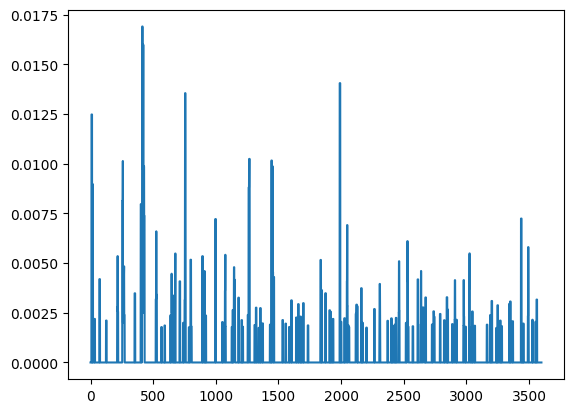

In [27]:
plt.plot(nm_metrics.at[roi,'mean_responses'])

In [13]:
roi = 0
roi_trial_resp = trial_responses[roi] # shape [natural image presentation, number trials]

# Compute preferred stimulus by taking argmax of mean responses
roi_mean_trial_resp = np.nanmean(roi_trial_resp, axis=1)
pref_img_idx = np.nanargmax(roi_mean_trial_resp)
pref_response = roi_mean_trial_resp[pref_img_idx]
pref_img = nm.image_indices[pref_img_idx]



In [66]:
null_dist_single_trial = nm._null_dist_single_trial[nm.is_roi_valid]
pref_stim_trial_responses = trial_responses[roi, pref_img_idx, :] # ROI responses for preferred stimulus condition
pref_stim_trial_responses = pref_stim_trial_responses[~np.isnan(pref_stim_trial_responses)].reshape(-1, 1) # drop nans (no stimulus presentation) and make column vector
p_values = np.mean(pref_stim_trial_responses < null_dist_single_trial[roi], axis=1) # p-values of responses when compared to null distribution

In [70]:
frac_sig = np.mean(p_values < nm.sig_p_thresh)
frac_sig

1.0

In [28]:
null_dist_single_trial = nm._null_dist_single_trial[nm.is_roi_valid]
null_dist_multi_trial = nm._null_dist_multi_trial[nm.is_roi_valid]

In [40]:
#Get spontaneous activity
tStart = nm.spont_stim_table.start.values; tEnd = nm.spont_stim_table.end.values

iStart = find_nearest(ts, tStart)
iEnd = find_nearest(ts, tEnd)

dff_spont = dff[:,iStart:iEnd]
deconv_dff_spont = deconv_dff[:,iStart:iEnd]


Text(0, 0.5, 'Deconvolved events')

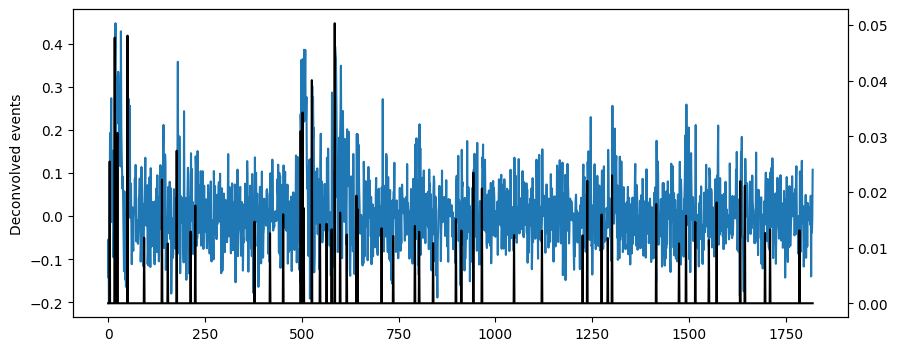

In [43]:
roi = 89

fig, ax = plt.subplots(figsize=(10,4))
ax2 = ax.twinx()
ax.plot(dff_spont[roi])
ax.set_ylabel('dff')
ax2.plot(deconv_dff_spont[roi],'-k')
ax2.set_ylabel('Deconvolved events')


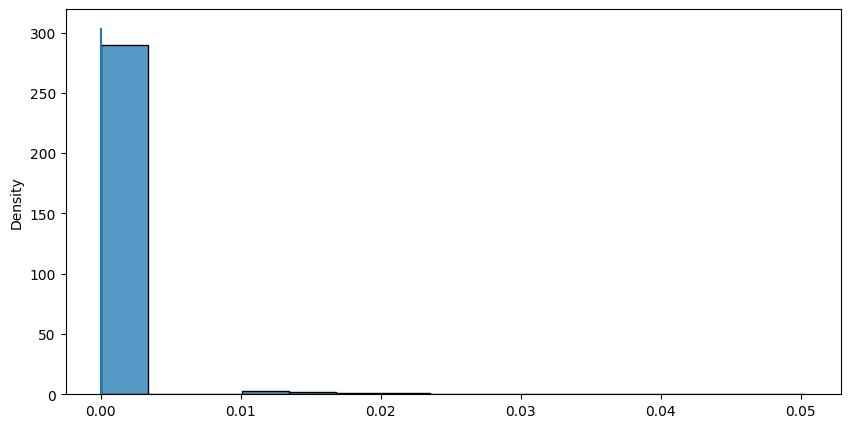

In [52]:
roi = 89
pref_img_idx = nm_metrics.at[roi,'pref_img_idx']
pref_stim_trial_responses = trial_responses[roi,pref_img_idx,:].reshape(-1,1)
tmp = pref_stim_trial_responses > null_dist_single_trial[roi]



fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(null_dist_single_trial[roi,:],stat='density')
ax.vlines(np.mean(pref_stim_trial_responses),*ax.get_ylim())


## Calculate natural movie metrics

In [3]:
mouse = 409828 # selected for EM
column = 1

session_ids = client.get_all_session_ids()
# session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column) and s[9] == "3"]
session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column)]

print("Sessions to load:")
print(session_ids)

Sessions to load:
['M409828_11', 'M409828_12', 'M409828_13', 'M409828_14', 'M409828_15', 'M409828_16', 'M409828_17', 'M409828_18', 'M409828_19', 'M409828_1a', 'M409828_1b', 'M409828_1c', 'M409828_1d', 'M409828_1e', 'M409828_1f']


In [4]:
sessions = []

for session_id in tqdm(session_ids):
    session = client.load_ophys_session(session_id=session_id)
    sessions.append(session)

print(f"Loaded {len(sessions)} ophys sessions")

  0%|          | 0/15 [00:00<?, ?it/s]

Loaded 15 ophys sessions


In [5]:
plane_info = [] # holds (mouse, column, volume, plane)
nm_list = []

with tqdm(desc="Loading natural scene analyses", total=sum(len(s.get_planes()) for s in sessions)) as pbar:
    for session in sessions:
        for plane in session.get_planes():
            plane_info.append((session.get_mouse_id(), session.get_column_id(), session.get_volume_id(), plane))
            nm_list.append(NaturalMovie(session, plane))

            pbar.update()

Loading natural scene analyses:   0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
for nm in nm_list: nm._metrics = None


# Concatenate across the different planes
print("Concatenating natural movie metrics...")
nm_metrics = StimulusAnalysis.concat_metrics(nm_list)

Concatenating natural movie metrics...


In [7]:
DF_SAVE_DIR = r"/home/dwyrick/Git/v1dd_surround_suppression/dataframes"
nm_metrics_file = path.join(DF_SAVE_DIR, "nm_metrics_col_v2.csv")

nm_metrics.to_csv(nm_metrics_file)


In [8]:
nm_metrics = nm_metrics.loc[nm_metrics.is_valid]

In [10]:
np.sum(nm_metrics['frac_responsive_trials'].values > 0.25)/len(nm_metrics)

0.573810994441013

## Read in natural movie metrics

In [20]:
DF_SAVE_DIR = r"/home/dwyrick/Git/v1dd_surround_suppression/dataframes"
nm_metrics_file = path.join(DF_SAVE_DIR, "nm_metrics_col_v2.csv")

nm_metrics = pd.read_csv(nm_metrics_file, index_col=0, low_memory=False); nm_metrics = nm_metrics.loc[nm_metrics.is_valid]
ns_metrics = pd.read_csv(path.join(DF_SAVE_DIR, "ns_metrics_window0-4.csv"),index_col=0, low_memory=False)


Text(0.5, 1.0, '0.573810994441013')

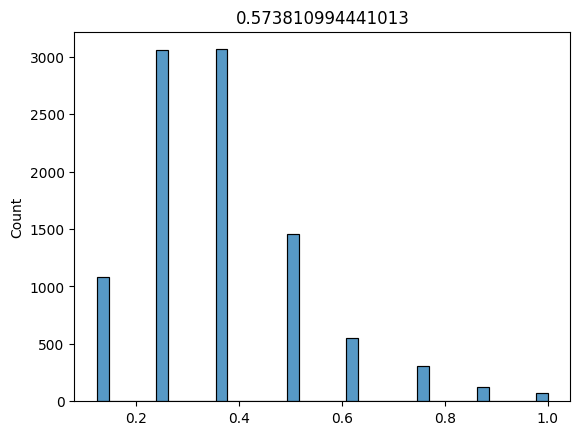

In [21]:
sns.histplot(nm_metrics['frac_responsive_trials'].values)
plt.title(np.sum(nm_metrics['frac_responsive_trials'].values > 0.25)/len(nm_metrics))

<AxesSubplot: ylabel='Count'>

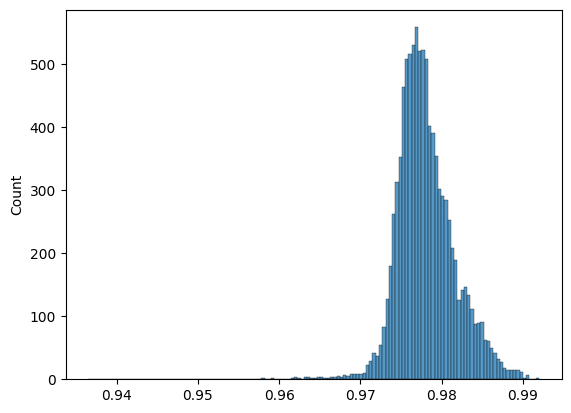

In [8]:
sns.histplot(nm_metrics['lifetime_sparseness'].values)

Text(0.5, 1.0, 'Natural Scenes (12): 0.136')

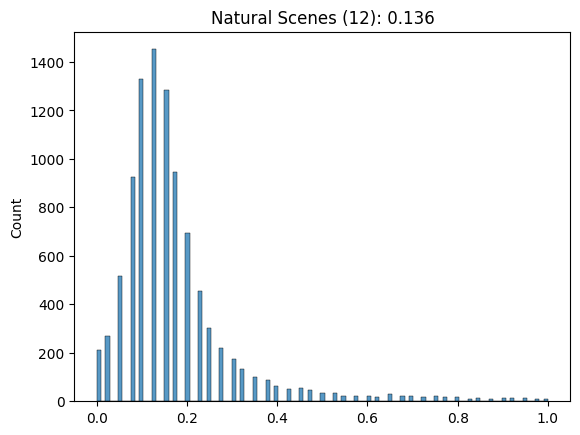

In [22]:
sns.histplot(ns_metrics['ns12_frac_responsive_trials'].values)
plt.title('Natural Scenes (12): {:.3f}'.format(np.sum(ns_metrics['ns12_frac_responsive_trials'].values > 0.25)/len(ns_metrics)))

Text(0.5, 1.0, 'Natural Scenes (118): 0.591')

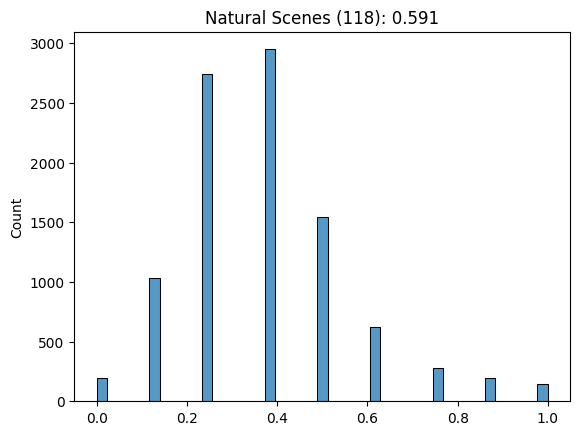

In [23]:
sns.histplot(ns_metrics['ns118_frac_responsive_trials'].values)
plt.title('Natural Scenes (118): {:.3f}'.format(np.sum(ns_metrics['ns118_frac_responsive_trials'].values > 0.25)/len(ns_metrics)))